In [ ]:
# This file uses SAM2 to mask the swimbladder of zebrafish in both side and top views. 
# Adapted from https://github.com/facebookresearch/sam2/blob/main/notebooks/video_predictor_example.ipynb
# Written by Kevin Li, May 2025

# Relevant imports
%matplotlib widget
import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import gc
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import cv2 as cv2

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True

from sam2.build_sam import build_sam2_video_predictor

# Loading model checkpoints, small works good enough
sam2_checkpoint = "sam2.1_hiera_small.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_s.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

gc.collect()
torch.cuda.empty_cache()


using device: cuda


In [ ]:
# Well video to segment, should have probably used os.join
name = 'B12'
folder = '15min'
video_dir = folder + "/well_" + name

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

ToggleButton(value=False, description='Toggle Active')

Button(description='Clear Points', style=ButtonStyle())

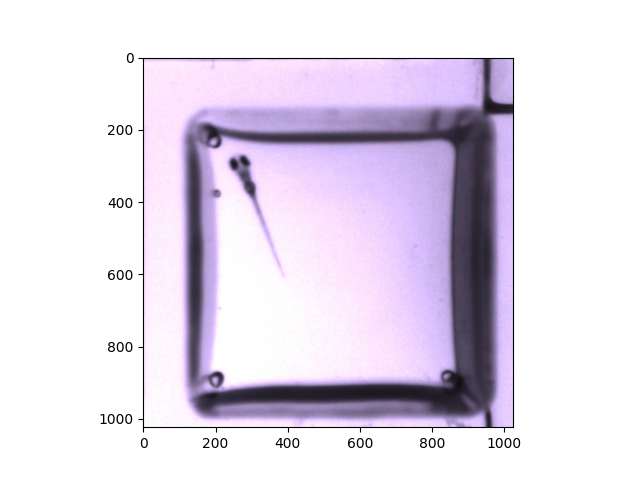

In [ ]:
img = mpimg.imread(os.path.join(video_dir, frame_names[0]))

clicked_points = []
active = False 

# This is a simple way using ipywidgets to click on points to record as input prompts rather than having to type it in manually.

def on_click(event):
    if active and event.xdata is not None and event.ydata is not None:  
        clicked_points.append((int(event.xdata), int(event.ydata)))
        colors = 'red'
        if len(clicked_points) <= 3:
            print('here')
            colors = 'green'
        ax.scatter(event.xdata, event.ydata, color=colors)
        fig.canvas.draw()

def toggle_active(change):
    global active
    active = change['new']

def clear_points(_):
    global clicked_points
    clicked_points = [] 
    ax.clear()
    ax.imshow(img)
    fig.canvas.draw()
    print("Points cleared.")

fig, ax = plt.subplots()
ax.imshow(img)

cid = fig.canvas.mpl_connect('button_press_event', on_click)

toggle_button = widgets.ToggleButton(value=False, description="Toggle Active")
toggle_button.observe(toggle_active, names='value')

clear_button = widgets.Button(description="Clear Points")
clear_button.on_click(clear_points)

display(toggle_button, clear_button)

plt.show()

In [4]:
inference_state = predictor.init_state(video_path=video_dir)

frame loading (JPEG): 100%|██████████| 1/1 [00:00<00:00, 34.42it/s]


In [5]:
predictor.reset_state(inference_state)

/home/kevinli/sam2/sam2/sam2_video_predictor.py:786: UserWarning: cannot import name '_C' from 'sam2' (/home/kevinli/sam2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(


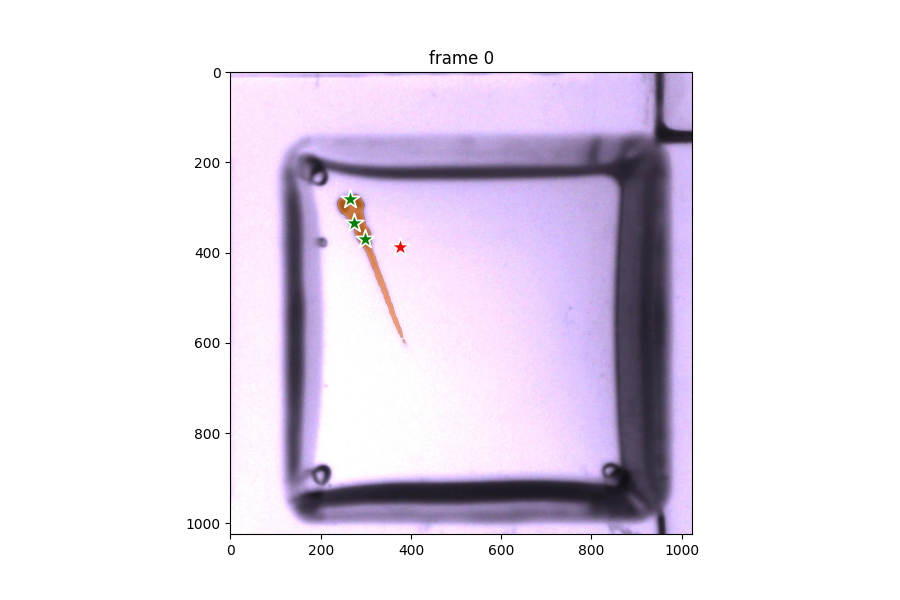

In [ ]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

points = np.array(clicked_points, dtype=np.float32)
# for labels, `1` means positive click and '0` means negative click
labels = np.zeros(len(points), dtype = np.int32)
labels[0:3] = 1
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)
plt.close()
# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

propagate in video: 100%|██████████| 1/1 [00:00<00:00, 1026.25it/s]


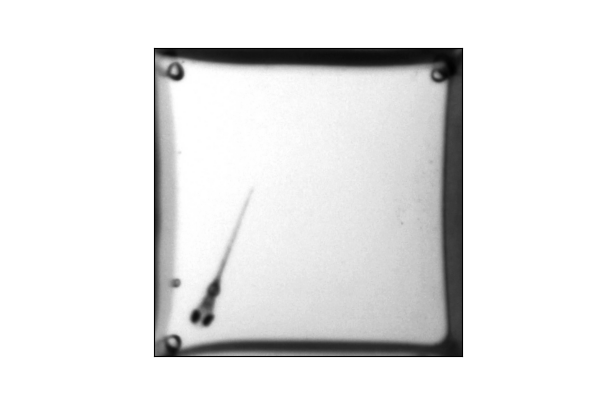

In [7]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 1
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    im = np.asarray(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    plt.imshow(im, cmap = 'gray')
    plt.xlim(150, 900)
    plt.ylim(200, 950)
    plt.xticks([])
    plt.yticks([])
    plt.title('')
    # for out_obj_id, out_mask in video_segments[out_frame_idx].items():
    #     show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

In [ ]:
# Saving the extracted masks as .npy files to be used in Swim Bladder Reconstruction
masks = []
output = 'filename.npy'
for i in range(0,len(video_segments)):
    mask = video_segments[i][1][0]
    masks.append(mask)

np.save(output, masks)